In [1]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2025-02-20 12:10:12.924604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-20 12:10:12.924623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import tensorflow as tf
print("GPUs disponibili:", tf.config.list_physical_devices('GPU'))

GPUs disponibili: []


2025-02-20 12:10:15.186757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-20 12:10:15.189263: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-20 12:10:15.189321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-02-20 12:10:15.189356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-02-20 12:10:15.189393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [3]:
import tensorflow as tf
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))


GPU disponibile: []


In [4]:
# Aggiungi al sys.path
sys.path.append("../preprocessing")

In [5]:
import sampling as samp

In [ ]:
df = samp.sampling_csv("../timeseries/B101/Channel1.csv", 4)
df.reset_index(drop=True, inplace=True)
display(df)

,singleData
0,-21702628.0
1,17132264.0
2,28665146.0
3,36802184.0
4,47670068.0
...,...
3071995,48777768.0
3071996,-10236032.0
3071997,-16138004.0
3071998,-25018178.0


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
df["scaledData"] = scaler.fit_transform(df[["singleData"]])

In [ ]:
# Creazione delle sequenze di input e target
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])   
        y.append(data[i+seq_length])     
        
    return np.array(X), np.array(y)

In [9]:
# Generare i dati di input e target
seq_length = 100
X, y = create_sequences(df["scaledData"].values, seq_length)

In [10]:
# Divisione in training e test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape per adattare il modello LSTM: (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [11]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2457520, 100, 1), y_train shape: (2457520,)
X_test shape: (614380, 100, 1), y_test shape: (614380,)


In [ ]:
# Creazione del modello LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),         # Primo strato LSTM
    LSTM(50, return_sequences=False),                                           # Secondo strato LSTM
    Dense(25, activation='relu'),                                               # Strato fully connected
    Dense(1)                                                                    # Output layer
])

2025-02-20 12:10:19.966927: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Compilazione del modello
model.compile(optimizer='adam', loss='mse')

In [14]:
# Addestramento del modello
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


2025-02-20 12:10:20.822302: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 983008000 exceeds 10% of free system memory.


76798/76798 [==============================] - ETA: 0s - loss: 0.0017

2025-02-20 12:56:23.650147: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245752000 exceeds 10% of free system memory.


76798/76798 [==============================] - 3000s 39ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 2/20
76798/76798 [==============================] - 2802s 36ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/20
76798/76798 [==============================] - 2821s 37ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/20
76798/76798 [==============================] - 2843s 37ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/20
76798/76798 [==============================] - 3024s 39ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/20
53579/76798 [===================>..........] - ETA: 14:31 - loss: 0.0016

KeyboardInterrupt: 

In [ ]:
# Valutazione del modello
loss = model.evaluate(X_test, y_test)
print(f"Loss sul test set: {loss}")

19200/19200 [==============================] - 266s 14ms/step - loss: 0.0016
Loss sul test set: 0.0016364625189453363


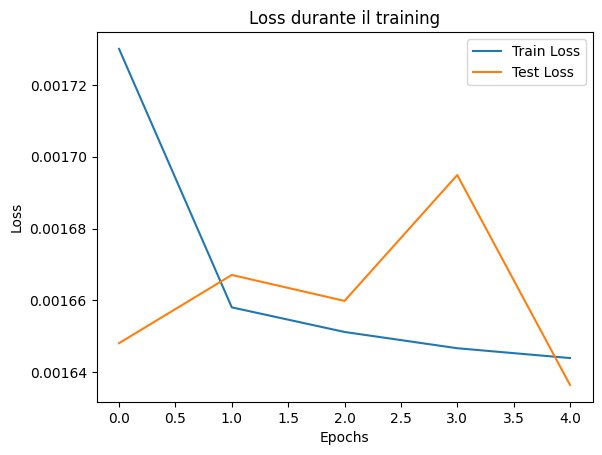

In [ ]:
# Visualizzazione della loss durante il training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss durante il training')
plt.show()